In [1]:
from numba import njit

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots


from dataclasses import dataclass
import numpy as np

import jax
import jax.numpy as jnp
import os

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
os.environ['XLA_PYTHON_CLIENT_ALLOCATOR'] = 'platform'

In [2]:
@dataclass
class HestonParams:
    kappa: float 
    mean: float
    gamma: float
    rho:float
    v0:float

    def to_array(self):
        return np.array([self.kappa, self.mean, self.gamma, self.rho, self.v0])

In [3]:
@jax.jit
def get_next_cir_value(kappa, mean, gamma, rho, v0, v_prev, dt, z1, z2):
    c_bar = gamma**2/4/kappa*(1 - jnp.exp(-kappa*dt))
    kappa_bar = 4*kappa*jnp.exp(-kappa*dt)/gamma**2/(1 - jnp.exp(-kappa*dt))*v_prev
    df = 4*kappa*mean/gamma**2
    mu = c_bar*(df + kappa_bar)
    var = c_bar**2*(2*df + 4*kappa_bar)
    b = jnp.sqrt(2*mu**2/var - 1 + jnp.sqrt(2*mu**2/var)*jnp.sqrt(2*mu**2/var - 1))
    a = mu/(1 + b**2)
    c = (var/mu**2 - 1 )/(var/mu**2 + 1)
    d = (1 - c)/mu
    flag = var/mu**2 <= 1.5
    return a*(b+z1)**2*flag + jnp.log((1-c)/(1-z2))/d*(z2>c)*(1-flag)

@jax.jit
def get_next_logprice_value(kappa, mean, gamma, rho, v0, T, s_prev, r, v_prev, v_curr, dt, z3):
    k0 = (r - rho/gamma*kappa*mean)*dt
    k1 = (rho/gamma*kappa - 0.5)*dt - rho/gamma
    k2 = rho/gamma
    k3 = (1 - rho**2)*dt
    return s_prev + k0 + k1*v_prev + k2*v_curr + jnp.sqrt(k3*v_prev)*z3

In [4]:
def get_paths(kappa, mean, gamma, rho, v0, T, S, r, N_paths, N_steps, key):
    dt = T/(N_steps-1)

    def step(carry, key):
        v_prev, s_prev = carry
        key1, key2, key3 = jax.random.split(key, 3)
        z1 = jax.random.normal(key1, (N_paths,)) 
        z2 = jax.random.uniform(key2, (N_paths,))
        z3 = jax.random.normal(key3, (N_paths,)) 
        
        v_next = get_next_cir_value(kappa, mean, gamma, rho, v0, v_prev, dt, z1, z2)
        s_next = get_next_logprice_value(kappa, mean, gamma, rho, v0, T, s_prev, r, v_prev, v_next, dt, z3)
        return (v_next, s_next), (v_next, s_next)

    keys = jax.random.split(key, N_steps-1)
    v_init = jnp.full(N_paths, v0)
    s_init = jnp.full(N_paths, jnp.log(S))
    _,  (v, s)= jax.lax.scan(step, (v_init, s_init), keys) 
    
    return jnp.vstack((v_init, v)).T, jnp.exp(jnp.vstack((s_init, s)).T)

get_paths = jax.jit(get_paths, static_argnums=(8, 9))

# American option pricing

The value of an american option is the value achieved by exercising optimally.


$m$ - number of time steps, $N$ - number of MC paths, $V_{i}$ - value at $i$ time step, $h(x)$ - payoff function; 

Formulation of the problem in dynamic-programming sense:

$V_{m}(x) = h(x)$ - value at maturity

$V_i(x) = max\{h(x), C_i(x)\}$, $i = 0,..., m-1$

Where $C_{i}(x) = \mathbb{E}_Q \left[V_{i+1}(x_{i+1})|x_{i}= x\right ] $ - Continuation value - value of holding rather than exercising;



We are interested in $V_0(x_0)$

In LSMC we approximate continuation value by linear combination of basis functions:


$$ C_i(x) = \sum_{k=0}^{d_1} \sum_{p=0}^{d_2} w_{kp} \, \phi_k(x_{1i}) \phi_p(x_{2i}) $$

Here $x^{i}_j = (x_{1i}, x_{2i})$, $x_{1i} - $ underlying price, $x_{2i} - $ volatility;

Our basis functions of choice are Chebyshev polynomials of the first kind. They are orthogonal on $[-1, 1]$, so the predictor scaling should be done.

Eventually we are solving the following least squares problem at each time step $i$:

$$ V_{i+1} = A(x_i)w = 
\left[
\begin{array}{cccc}
\phi_0(x_{1i}^1)\phi_0(x_{2i}^1) & \phi_0(x_{1i}^1)\phi_1(x_{2i}^1) & \cdots & \phi_{d_1}(x_{1i}^1)\phi_{d_2}(x_{2i}^1) \\
\phi_0(x_{1i}^2)\phi_0(x_{2i}^2) & \phi_0(x_{1i}^2)\phi_1(x_{2i}^2) & \cdots & \phi_{d_1}(x_{1i}^2)\phi_{d_2}(x_{2i}^2) \\
\vdots & \vdots & \ddots & \vdots \\
\phi_0(x_{1i}^N)\phi_0(x_{2i}^N) & \cdots & \cdots & \phi_{d_1}(x_{1i}^N)\phi_{d_2}(x_{2i}^N)
\end{array}
\right]
\left[
\begin{array}{c}
w_{00} \\ w_{01} \\ \vdots \\ w_{0d_2} \\ w_{10} \\ w_{11} \\ \vdots \\ w_{d_1d_2}
\end{array}
\right] $$



Unlike original approach we take only those paths which discounted values at the next time step are positive.

Parameters:

In [17]:
key = jax.random.key(37)

S = 40.0
T = 1.0
K = 40.0
r = 0.06


heston_params = HestonParams(
    kappa = 1.5768, 
    mean = 0.0898,
    gamma = 0.3551,
    rho = -0.5711,
    v0 = 0.142
)

N_paths = 50_000
N_steps = 500
dt = T/(N_steps - 1)
discount = np.exp(-dt*r)
volatility_paths, price_paths = get_paths(*heston_params.to_array(), T, S, r, N_paths, N_steps, key)

asset_prices = np.array(price_paths)
volatility = np.sqrt(volatility_paths)
payoff = lambda s: np.maximum(0, K - s)
option_values = np.zeros((N_paths, N_steps))
option_values[:, -1] = payoff(asset_prices[:, -1])

def mc_price(K, r, T, terminal_prices):
    return np.exp(-r*T)*np.mean(np.maximum(K - terminal_prices, 0))

In [18]:
@njit
def chebyshev(x, d):
    
    n = x.size
    result = np.zeros((n, d + 1))
    
    # T_0(x) = 1
    result[:, 0] = 1.0
    
    if d == 0:
        return result
    
    # T_1(x) = x
    result[:, 1] = x
    
    if d == 1:
        return result
    
    # Recurrence relation: T_n(x) = 2x * T_{n-1}(x) - T_{n-2}(x)
    for i in range(2, d + 1):
        result[:, i] = 2 * x * result[:, i - 1] - result[:, i - 2]
    
    return result

@njit
def A_matrix(x1, x2, d1, d2):
    basis_1 = chebyshev(x1, d1)
    basis_2 = chebyshev(x2, d2)

    design_matrix = np.zeros((x1.size, (d1+1)*(d2+1)))
    for i in range(x1.size):
        design_matrix[i, :] = np.outer(basis_1[i, :], basis_2[i, :]).flatten()
        
    return design_matrix

Illustration of the algo:

In [19]:
X1 = asset_prices[:, -2]
X2 = volatility[:, -2]

X1_scaled = 2*(X1 - X1.min())/(X1.max() - X1.min()) - 1 
X2_scaled = 2*(X2 - X2.min())/(X2.max() - X2.min()) - 1 
V = discount*payoff(asset_prices[:, -1])

idx = np.where(V > 0.0)[0]

In [20]:
d1 = 2
d2 = 1
A = A_matrix(X1_scaled, X2_scaled, d1, d2)

coef = np.linalg.lstsq(A[idx], V[idx])[0]
V_hat = np.matmul(A, coef)

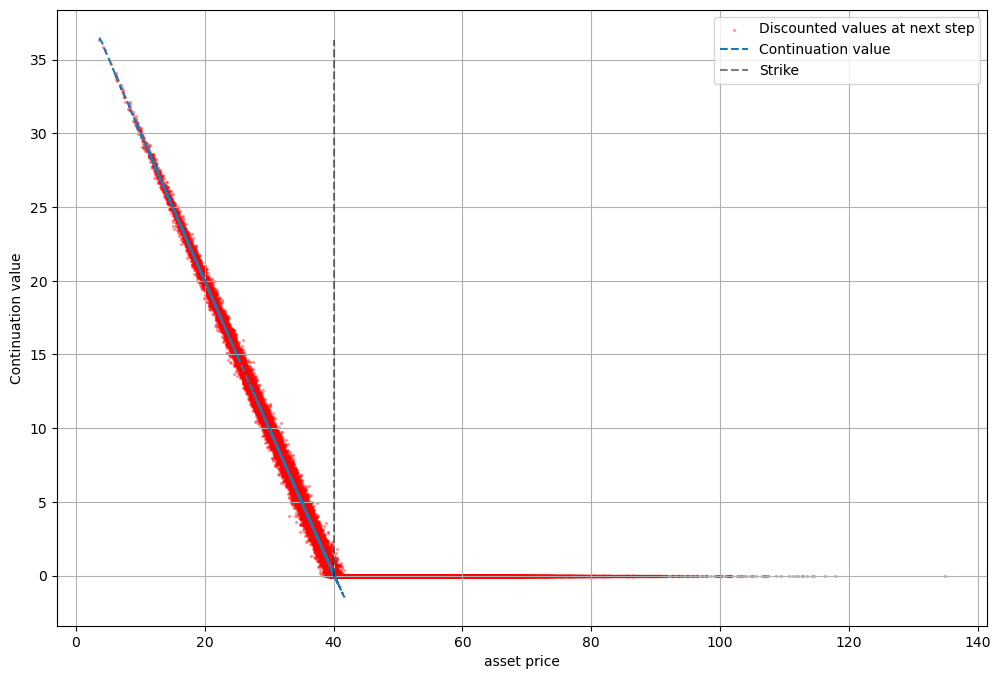

In [21]:
plt.figure(figsize = (12, 8))
plt.scatter(X1, V, c = 'red', s = 2, alpha = 0.3, label = 'Discounted values at next step')
plt.plot(X1[idx][np.argsort(X1[idx])], V_hat[idx][np.argsort(X1[idx])], ls = '--', label = 'Continuation value')
plt.plot([K, K], [0, np.max(V)], alpha = 0.5, c = 'black', ls = '--', label = 'Strike')
plt.xlabel('asset price')
plt.ylabel('Continuation value')
plt.legend()
plt.grid()

Pricing and comparison with European option for the list of current asset prices:

In [22]:
american_values = list()
european_values = list()
S_list = np.linspace(K*0.5, K*1.5, 20)
for S in S_list:
    volatility_paths, price_paths = get_paths(*heston_params.to_array(), T, S, r, N_paths, N_steps, key)
    asset_prices = np.array(price_paths)
    volatility = np.sqrt(volatility_paths)
    
    option_values = np.zeros((N_paths, N_steps))
    option_values[:, -1] = payoff(asset_prices[:, -1])


    for j in range(N_steps-2, 0, -1):
        X1, X2, V = asset_prices[:, j], volatility[:, j], discount*option_values[:, j+1]
        idx = np.where(V > 0)[0]
        X1_scaled = 2*(X1 - X1.min())/(X1.max() - X1.min()) - 1 
        X2_scaled = 2*(X2 - X2.min())/(X2.max() - X2.min()) - 1
    
        d1 = 2
        d2 = 1
        A = A_matrix(X1_scaled, X2_scaled, d1, d2)
        coef = np.linalg.lstsq(A[idx], V[idx])[0]
        
        cont = np.matmul(A, coef)
        option_values[:, j] = np.where(payoff(X1) >= cont, payoff(X1), cont)


    american_values.append(discount*np.mean(option_values[:,1]))
    european_values.append(mc_price(K, r, T, asset_prices[:, -1]))
    
american_values = np.array(american_values)
european_values = np.array(european_values)

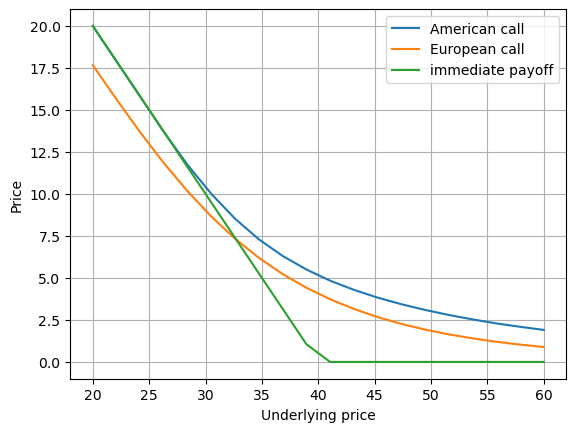

In [23]:
plt.plot(S_list, american_values, label = 'American call')
plt.plot(S_list, european_values, label = 'European call')
plt.plot(S_list, payoff(S_list), label = 'immediate payoff')
plt.xlabel('Underlying price')
plt.ylabel('Price')
plt.grid()
plt.legend()
plt.show()